In [4]:
import keras.backend as K
import cv2
import numpy as np
import math

from PIL import Image
import time
import pickle
import sklearn.svm
import configparser

from matplotlib import pyplot as plt
%matplotlib inline

import load
import cnn
import get_info

## Size of images

In [20]:
train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = load.two_balanced_classes()
ids = train_ids + val_ids + test_ids

In [23]:
N = len(ids)
print("%d images"%N)
sizes = np.zeros((N, 2))
for i, ident in enumerate(ids):
    ident = ident_list[i]
    filename = roof_cache_dir + str(ident) + '.jpg'
    image = Image.open(filename)
    x, y = image.size
    sizes[i, 0] = x
    sizes[i, 1] = y

6000 images


array([ 95.432     ,  92.69883333])

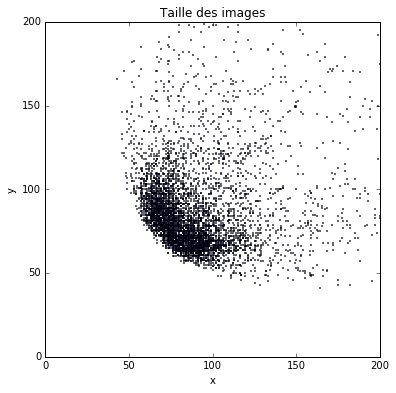

In [41]:
# plot sizes of images
plt.figure(figsize=(6, 6))
plt.scatter(sizes[:, 0], sizes[:, 1], s=0.5)
plt.axis('equal')
plt.xlim([0,200])
plt.ylim([0,200])
plt.title('Taille des images')
plt.xlabel('x')
plt.ylabel('y')
sizes.mean(axis=0)

In [18]:
sizes

array([[ 77.,  64.],
       [ 77.,  64.],
       [ 77.,  64.],
       ..., 
       [ 77.,  64.],
       [ 77.,  64.],
       [ 77.,  64.]])

## Tests on roof images

In [ ]:
#model.layers[1].W.get_value().shape
#model.layers[29].W.get_value().shape
len(model.layers)

In [ ]:
get_layer_functions = {}
for i in range(len(model.layers)):
    get_layer_functions[i] = K.function([model.layers[0].input],
                                  [model.layers[i].get_output(train=False)])

In [ ]:
three_features = layer_output[0, 4:7, :, :]
three_features = np.swapaxes(three_features, 0, 2)
three_features.shape
plt.imshow(three_features)

In [ ]:
i_layer = 31
lo0 = get_layer_functions[i_layer]([im0])[0]
lo1 = get_layer_functions[i_layer]([im1])[0]

## Use the CNN features to train a classifier

In [42]:
train_ids, val_ids, test_ids, train_labels, val_labels, test_labels = load.two_balanced_classes()

In [43]:
cnn_train = cnn.get_cnn_features(train_ids)

In [44]:
cnn_val = cnn.get_cnn_features(val_ids)

In [45]:
cnn_test = cnn.get_cnn_features(test_ids)

In [46]:
n_C = 20
C_list = np.logspace(-10, 10, n_C)
errors = np.zeros(n_C)
for i, C in enumerate(C_list):
    model = sklearn.linear_model.LogisticRegression(penalty='l2', C=C)
    t = time.time()
    model.fit(cnn_train, train_labels)
    print("LR took %f seconds."%(time.time()-t))
    predictions = model.predict(cnn_val)
    errors[i] = (val_labels!=predictions).sum()/len(val_labels)

LR took 0.494086 seconds.
LR took 0.607477 seconds.
LR took 0.596577 seconds.
LR took 0.828180 seconds.
LR took 1.643284 seconds.
LR took 2.973459 seconds.
LR took 5.369043 seconds.
LR took 8.158056 seconds.
LR took 8.689127 seconds.
LR took 7.593839 seconds.
LR took 8.410516 seconds.
LR took 8.427809 seconds.
LR took 8.632214 seconds.
LR took 8.447658 seconds.
LR took 8.498361 seconds.
LR took 8.516274 seconds.
LR took 8.513020 seconds.
LR took 8.460361 seconds.
LR took 8.432689 seconds.
LR took 8.431569 seconds.


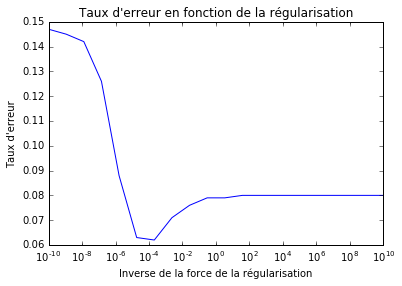

In [50]:
plt.plot(C_list, errors)
plt.title("Taux d'erreur en fonction de la régularisation")
plt.ylabel("Taux d'erreur")
plt.xlabel("Inverse de la force de la régularisation")
plt.xscale('log')

In [48]:
i_opt = np.argmin(errors)
C_opt = C_list[i_opt] #0.000018#
print('optimal C : %f'%C_opt)
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=C_opt)
t = time.time()
model.fit(cnn_train, train_labels)
print("LR took %f seconds."%(time.time()-t))
predictions = model.predict(cnn_test)
err = (test_labels!=predictions).sum()/len(test_labels)

optimal C : 0.000207
LR took 5.278618 seconds.


In [49]:
err

0.070000000000000007

In [38]:
cnn_proba_val = model.predict_proba(cnn_val)[:,0]
cnn_proba_test = model.predict_proba(cnn_test)[:,0]

## Visualize some wrong predictions

In [58]:
indexes_wrong = np.where(test_labels!=predictions)[0]

In [77]:
indexes_wrong = np.where(test_labels!=predictions)[0]
def show_wrong():
    i = np.random.choice(indexes_wrong)
    ident = test_ids[i]

    directory = load.data_dir + 'roof_images/'
    image = np.array(Image.open(directory + str(ident) + '.jpg'))

    plt.figure()
    plt.imshow(image)

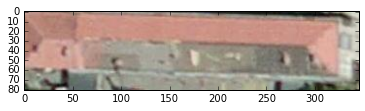

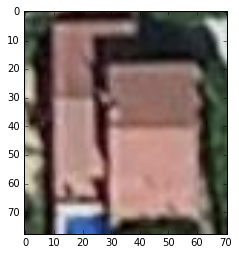

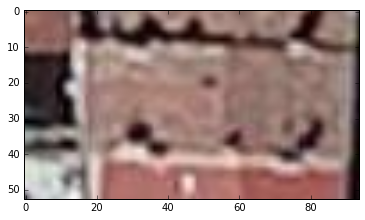

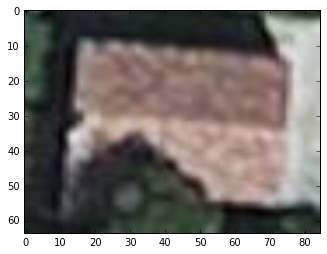

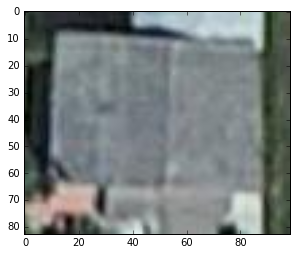

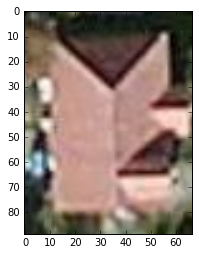

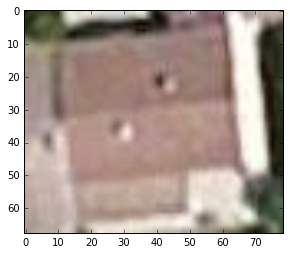

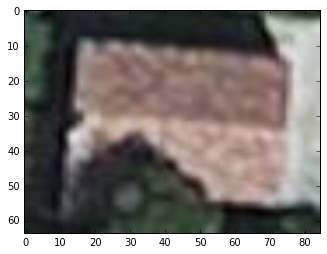

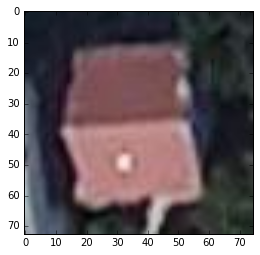

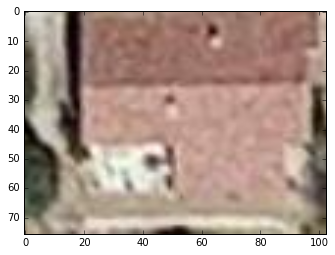

In [79]:
for i in range(10):
    show_wrong()

In [80]:
indexes_right = np.where(test_labels==predictions)[0]
def show_right():
    i = np.random.choice(indexes_right)
    ident = test_ids[i]

    directory = load.data_dir + 'roof_images/'
    image = np.array(Image.open(directory + str(ident) + '.jpg'))

    plt.figure()
    plt.imshow(image)

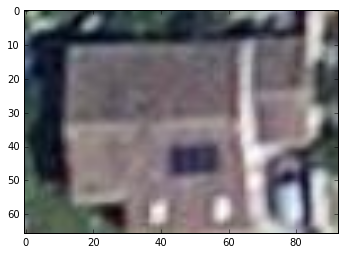

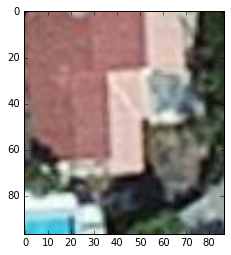

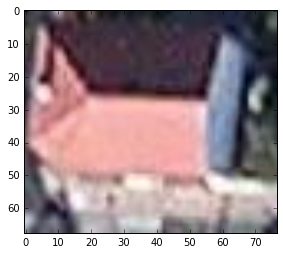

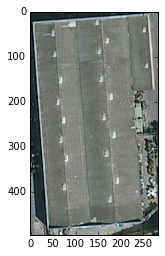

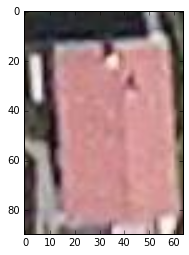

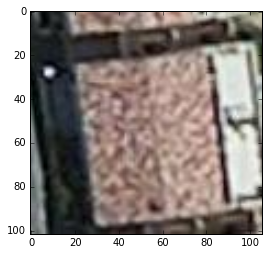

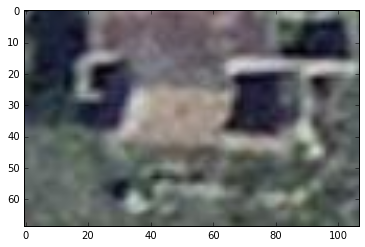

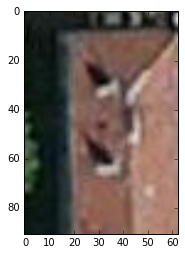

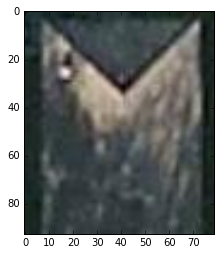

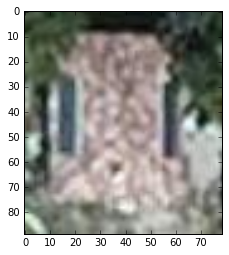

In [81]:
for i in range(10):
    show_right()

# Mix with other features

In [3]:
l = 6
color = False
train_reduc, val_reduc, test_reduc = load.load_all_data(train_ids, val_ids, test_ids, l, color)

In [9]:
train_ids[0]

'199851982'

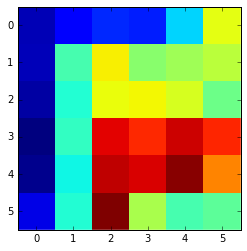

In [16]:
plt.imshow(train_reduc[0].reshape(6, 6), interpolation='none')

In [41]:
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10)
model.fit(train_reduc, train_labels)
predictions = model.predict(val_reduc)
error = (val_labels!=predictions).sum()/len(val_labels)
error

0.114

In [42]:
reduc_proba_val = model.predict_proba(val_reduc)[:,0]
reduc_proba_test = model.predict_proba(test_reduc)[:,0]

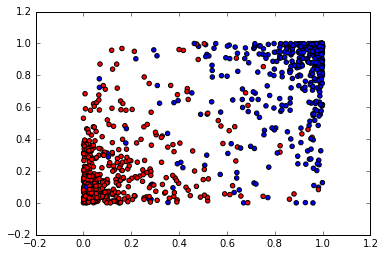

In [47]:
def colorize(labels):
    return ['b' if l==1 else 'r' for l in labels]
plt.scatter(cnn_proba_val, reduc_proba_val, c=colorize(val_labels))

In [50]:
N_val = len(reduc_proba_val)
val_mix = np.zeros((N_val, 2))
val_mix[:, 0] = cnn_proba_val
val_mix[:, 1] = reduc_proba_val
N_test = len(reduc_proba_test)
test_mix = np.zeros((N_test, 2))
test_mix[:, 0] = cnn_proba_test
test_mix[:, 1] = reduc_proba_test

In [51]:
model = sklearn.linear_model.LogisticRegression(penalty='l2', C=1e10)
model.fit(val_mix, val_labels)
predictions = model.predict(test_mix)
error = (test_labels!=predictions).sum()/len(test_labels)
error

0.048000000000000001

In [52]:
probas = model.predict_proba(test_mix)

## Confidence

In [55]:
confidence = np.max(probas, axis=1)

(array([   1.,    4.,    3.,    1.,    1.,    1.,    1.,    0.,    2.,
           1.,    0.,    0.,    0.,    5.,    1.,    1.,    0.,    3.,
           1.,    1.,    3.,    2.,    0.,    2.,    1.,    1.,    0.,
           3.,    2.,    1.,    3.,    0.,    0.,    0.,    2.,    2.,
           0.,    0.,    2.,    0.,    1.,    1.,    1.,    3.,    0.,
           0.,    4.,    4.,    1.,    1.,    4.,    1.,    2.,    5.,
           1.,    1.,    4.,    0.,    3.,    2.,    2.,    4.,    4.,
           2.,    5.,    2.,    3.,    3.,    1.,    4.,    3.,    2.,
           4.,    2.,    3.,    5.,    6.,    0.,    4.,    3.,    5.,
           7.,   15.,    4.,   10.,    7.,    5.,   10.,    4.,   11.,
          13.,   15.,   15.,   18.,   23.,   34.,   61.,   80.,  166.,  345.]),
 array([ 0.5004647 ,  0.50539714,  0.51032958,  0.51526202,  0.52019446,
         0.5251269 ,  0.53005933,  0.53499177,  0.53992421,  0.54485665,
         0.54978909,  0.55472153,  0.55965397,  0.56458641,  0.5

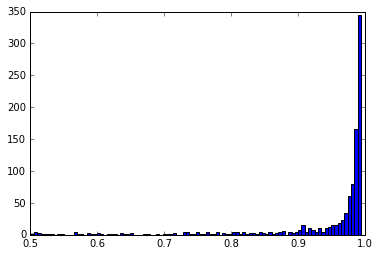

In [56]:
plt.hist(confidence, bins=100)

In [123]:
N = len(confidence)
confidence_order = np.argsort(-confidence)
sorted_error = (predictions[confidence_order]!=test_labels[confidence_order])
nb_errors = np.cumsum(sorted_error)
error_rate = nb_errors/np.arange(N_test)

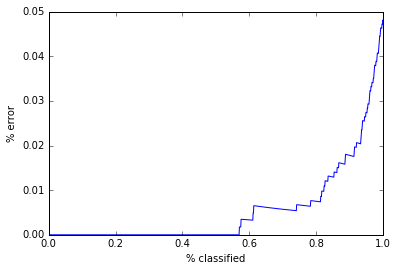

In [125]:
plt.plot(np.arange(N)/N, error_rate)
plt.xlabel('% classified')
plt.ylabel('% error')

In [126]:
def custom_convolution(a, kernel):
    n = len(a)
    k = int((len(kernel)-1)/2)
    
    conv = np.zeros(n)
    for i in range(n):
        imin_kernel = max(0, k-i)
        imax_kernel = min(2*k+1, k+n-i)
        imin_a = max(0, i-k)
        imax_a = min(n, k+1+i)
        conv[i] = (a[imin_a:imax_a]*kernel[imin_kernel:imax_kernel]).sum() / (kernel[imin_kernel:imax_kernel].sum())
    
    return conv

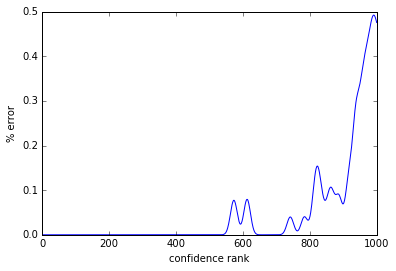

In [130]:
sigma = 10.
kernel_size = int(math.floor(3.5*sigma))
kernel = np.exp(-np.power(np.arange(2*kernel_size+1)-kernel_size, 2.)/(2*np.power(sigma, 2.)))
kernel /= kernel.sum()

smooth_error = custom_convolution(sorted_error, kernel)
plt.figure()
plt.plot(smooth_error)
plt.xlabel('confidence rank')
plt.ylabel('% error')